In [1]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import keras
from keras import ops
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds

tfds.disable_progress_bar()

SEEDS = 42

keras.utils.set_random_seed(SEEDS)

2025-10-30 14:49:12.596593: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/xy/Desktop/ml/keras/test/keras_test/lib/python3.10/site-packages/tensorflow_hub/__init__.py:61: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import parse_version


In [2]:
train_ds, validation_ds = tfds.load(
    "tf_flowers",
    split=["train[:85%]", "train[85%:]"],
    as_supervised=True,
)

I0000 00:00:1761832156.687461    9244 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9110 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:08:00.0, compute capability: 7.5


2025-10-30 14:49:24.840620: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:396] The default buffer size is 262144, which is overridden by the user specified `buffer_size` of 8388608
2025-10-30 14:49:24.990643: W tensorflow/core/kernels/data/cache_dataset_ops.cc:917] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2025-10-30 14:49:24.995740: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


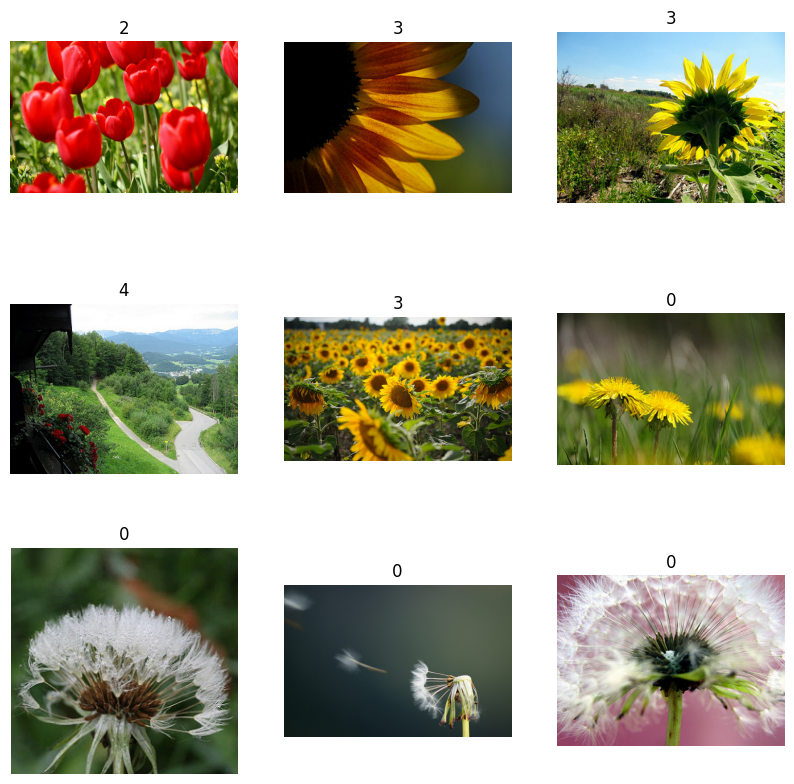

In [3]:
plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(train_ds.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.title(int(label))
    plt.axis("off")

In [4]:
RESIZE_TO = 384
CROP_TO = 224
BATCH_SIZE = 10
STEPS_PER_EPOCH = 10
AUTO = tf.data.AUTOTUNE  # optimise the pipeline performance
NUM_CLASSES = 5  # number of classes
SCHEDULE_LENGTH = (
    500  # we will train on lower resolution images and will still attain good results
)
SCHEDULE_BOUNDARIES = [
    200,
    300,
    400,
]  # more the dataset size the schedule length increase

In [6]:
SCHEDULE_LENGTH = SCHEDULE_LENGTH

random_flip = keras.layers.RandomFlip("horizontal")
random_crop = keras.layers.RandomCrop(CROP_TO, CROP_TO)

def preprocess_train(image, label):
    image = random_flip(image)
    image = ops.image.resize(image, (RESIZE_TO, RESIZE_TO))
    image = random_crop(image)
    image = image / 255.0
    return (image, label)


def preprocess_test(image, label):
    image = ops.image.resize(image, (RESIZE_TO, RESIZE_TO))
    image = ops.cast(image, dtype="float32")
    image = image / 255.0
    return (image, label)


DATASET_NUM_TRAIN_EXAMPLES = train_ds.cardinality().numpy()

repeat_count = int(
    SCHEDULE_LENGTH / STEPS_PER_EPOCH
)
repeat_count += 50 + 1  # To ensure at least there are 50 epochs of training

In [7]:
# Training pipeline
pipeline_train = (
    train_ds.shuffle(10000)
    .repeat(repeat_count)  # Repeat dataset_size / num_steps
    .map(preprocess_train, num_parallel_calls=AUTO)
    .batch(5)
    .prefetch(AUTO)
)

# Validation pipeline
pipeline_validation = (
    validation_ds.map(preprocess_test, num_parallel_calls=AUTO)
    .batch(5)
    .prefetch(AUTO)
)

2025-10-30 14:50:46.890540: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: CANCELLED: RecvAsync is cancelled.
	 [[{{node GroupCrossDeviceControlEdges_0/NoOp/_21}}]] [type.googleapis.com/tensorflow.DerivedStatus='']
2025-10-30 14:50:46.890574: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: CANCELLED: RecvAsync is cancelled.
	 [[{{node GroupCrossDeviceControlEdges_0/NoOp/_21}}]] [type.googleapis.com/tensorflow.DerivedStatus='']
2025-10-30 14:50:46.890585: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17668832687032015080
2025-10-30 14:50:46.890595: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17668832687032015080
2025-10-30 14:50:46.890603: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8219878593435437361
2025-10-30 14:50:46.89060

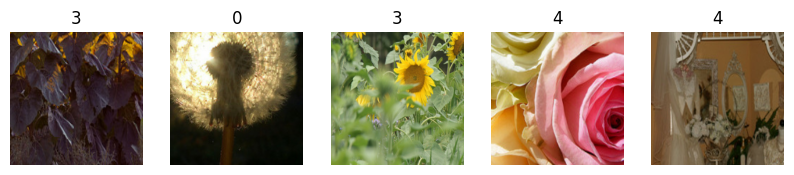

In [8]:
image_batch, label_batch = next(iter(pipeline_train))

plt.figure(figsize=(10, 10))
for n in range(5):
    ax = plt.subplot(5, 5, n + 1)
    plt.imshow(image_batch[n])
    plt.title(label_batch[n].numpy())
    plt.axis("off")

In [9]:
bit_model_url = "https://tfhub.dev/google/bit/m-r50x1/1"
bit_module = hub.load(bit_model_url)

In [10]:
class MyBiTModel(keras.Model):
    def __init__(self, num_classes, module, **kwargs):
        super().__init__(**kwargs)

        self.num_classes = num_classes
        self.head = keras.layers.Dense(num_classes, kernel_initializer="zeros")
        self.bit_model = module

    def call(self, images):
        bit_embedding = self.bit_model(images)
        return self.head(bit_embedding)


model = MyBiTModel(num_classes=NUM_CLASSES, module=bit_module)

In [11]:
learning_rate = 0.003 * BATCH_SIZE / 512

# Decay learning rate by a factor of 10 at SCHEDULE_BOUNDARIES.
lr_schedule = keras.optimizers.schedules.PiecewiseConstantDecay(
    boundaries=SCHEDULE_BOUNDARIES,
    values=[
        learning_rate,
        learning_rate * 0.1,
        learning_rate * 0.01,
        learning_rate * 0.001,
    ],
)
optimizer = keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.9)

loss_fn = keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [12]:
model.compile(optimizer=optimizer, loss=loss_fn, metrics=["accuracy"])

In [13]:
train_callbacks = [
    keras.callbacks.EarlyStopping(
        monitor="val_accuracy", patience=2, restore_best_weights=True
    )
]

In [14]:
history = model.fit(
    pipeline_train,
    batch_size=5,
    epochs=5,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_data=pipeline_validation,
    callbacks=train_callbacks,
)

Epoch 1/5


2025-10-30 14:52:03.127761: I external/local_xla/xla/service/service.cc:163] XLA service 0x73b15c025de0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-10-30 14:52:03.127775: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 2080 Ti, Compute Capability 7.5
2025-10-30 14:52:03.293544: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-10-30 14:52:04.163176: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91002
2025-10-30 14:52:07.558053: E external/local_xla/xla/service/slow_operation_alarm.cc:73] Constant folding an instruction is taking > 1s:

  %reduce-window.286 = f32[5,56,56,64]{3,2,1,0} reduce-window(%constant.1312, %constant.281), window={size=1x3x3x1 stride=1x2x2x1}, to_apply=%max_F32.282, metadata={op_type="MaxPool" op_name="my_bi_t_model_1/St

 1/10 ━━━━━━━━━━━━━━━━━━━━ 2:13 15s/step - accuracy: 0.6000 - loss: 1.6094

I0000 00:00:1761832331.896111    9374 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


 7/10 ━━━━━━━━━━━━━━━━━━━━ 22s 8s/step - accuracy: 0.3947 - loss: 1.5750

2025-10-30 14:53:02.680826: E external/local_xla/xla/service/slow_operation_alarm.cc:73] Constant folding an instruction is taking > 2s:

  %reduce-window.286 = f32[5,56,56,64]{3,2,1,0} reduce-window(%constant.1312, %constant.281), window={size=1x3x3x1 stride=1x2x2x1}, to_apply=%max_F32.282, metadata={op_type="MaxPool" op_name="my_bi_t_model_1/StatefulPartitionedCall/StatefulPartitionedCall/StatefulPartitionedCall/root_block/StatefulPartitionedCall/max_pooling2d/MaxPool" source_file="dummy_file_name" source_line=10}

This isn't necessarily a bug; constant-folding is inherently a trade-off between compilation time and speed at runtime. XLA has some guards that attempt to keep constant folding from taking too long, but fundamentally you'll always be able to come up with an input program that takes a long time.

If you'd like to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
2025-10-30 14:53:02.766201: E external/local_xla/xla/service/slow_operation_a

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.3821 - loss: 1.5484

2025-10-30 14:53:22.011048: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-10-30 14:53:22.133878: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-10-30 14:53:22.334168: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-10-30 14:53:22.470138: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-10-30 14:53:22.678969: E external/local_xla/xla/stream_

10/10 ━━━━━━━━━━━━━━━━━━━━ 92s 9s/step - accuracy: 0.4000 - loss: 1.4219 - val_accuracy: 0.8255 - val_loss: 0.9423
Epoch 2/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 80s 8s/step - accuracy: 0.9000 - loss: 0.6122 - val_accuracy: 0.9564 - val_loss: 0.4396
Epoch 3/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 79s 8s/step - accuracy: 0.9600 - loss: 0.3440 - val_accuracy: 0.9691 - val_loss: 0.2646
Epoch 4/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 78s 8s/step - accuracy: 0.9800 - loss: 0.1987 - val_accuracy: 0.9709 - val_loss: 0.2193
Epoch 5/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 81s 8s/step - accuracy: 0.9800 - loss: 0.1553 - val_accuracy: 0.9745 - val_loss: 0.1821


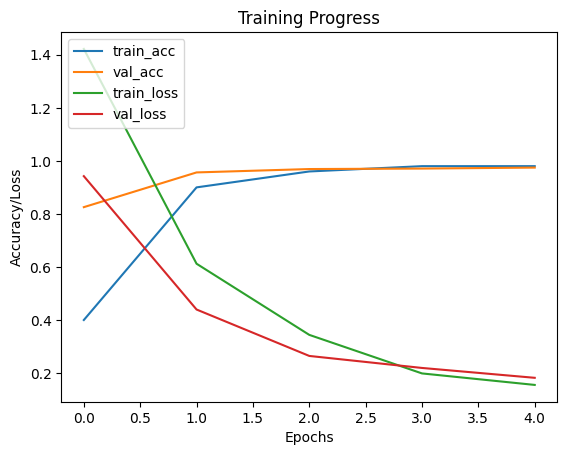

In [15]:
def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.plot(hist.history["loss"])
    plt.plot(hist.history["val_loss"])
    plt.title("Training Progress")
    plt.ylabel("Accuracy/Loss")
    plt.xlabel("Epochs")
    plt.legend(["train_acc", "val_acc", "train_loss", "val_loss"], loc="upper left")
    plt.show()


plot_hist(history)

In [16]:
accuracy = model.evaluate(pipeline_validation)[1] * 100
print("Accuracy: {:.2f}%".format(accuracy))

110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.9745 - loss: 0.1821
Accuracy: 97.45%
